In [1]:
%matplotlib inline 
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os 
import gcsfs 
from matplotlib import cm
import warnings 
import yaml
import pandas as pd

# from science_validation_manual import *

In [2]:
import dask
import dask.array as da
import dask.distributed as dd
import rhg_compute_tools.kubernetes as rhgk
import zarr
from tqdm.auto import tqdm

/tmp/ipykernel_17459/3374947116.py:4: DeprecationWarning: rhg_compute_tools and the associated command-line application rctools are
deprecated on catalyst clusters. use catalyst_compute_tools instead.
See https://gitlab.com/crs-catalyst/infrastructure/catalyst_compute_tools/-/issues/1
  import rhg_compute_tools.kubernetes as rhgk


In [3]:
plot_dir = '/home/jovyan/paper_figures'

In [ ]:
pr_hist = xr.open_zarr('gs://downscaled-48ec31ab/diagnostics/post-processing/pr/CanESM5/historical/post_processed_timestep_count.zarr', consolidated=True)

pr_ssp245 = xr.open_zarr('gs://downscaled-48ec31ab/diagnostics/post-processing/pr/CanESM5/ssp245/post_processed_timestep_count.zarr', consolidated=True)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

pr_hist['num_timesteps_clipped'].plot(ax=axes[0], robust=True)
pr_ssp245['num_timesteps_clipped'].plot(ax=axes[1], robust=True)
axes[0].set_title('1960-1980')
axes[1].set_title('SSP2-4.5, 2080-2100')

In [ ]:
tasmax_hist = xr.open_zarr('gs://downscaled-48ec31ab/diagnostics/post-processing/tasmax/CanESM5/historical/post_processed_timestep_count.zarr', consolidated=True)

tasmax_ssp245 = xr.open_zarr('gs://downscaled-48ec31ab/diagnostics/post-processing/tasmax/CanESM5/ssp245/post_processed_timestep_count.zarr', consolidated=True)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

tasmax_hist['num_timesteps_clipped'].plot(ax=axes[0], robust=True)
tasmax_ssp245['num_timesteps_clipped'].plot(ax=axes[1], robust=True)
axes[0].set_title('1960-1980')
axes[1].set_title('SSP2-4.5, 2080-2100')

pull in all models for a defined scenario 

In [4]:
import sys
sys.path.insert(1, '/home/jovyan/downscaleCMIP6/notebooks/downscaling_pipeline/post_processing_and_delivery/')
import dc6_functions

models = dc6_functions.get_cmip6_models()
institutions = dc6_functions.get_cmip6_institutions()
ensemble_members = dc6_functions.get_cmip6_ensemble_members()
# rename variable attributes
long_names = {'tasmax': 'Monthly mean of Daily Maximum Near-Surface Air Temperature', 'tasmin': 'Monthly mean of Daily Minimum Near-Surface Air Temperature', 'pr': 'Monthly sum of Daily Total Precipitation', 'tavg': 'Monthly mean of Daily Average Near-Surface Air Temperature'}

In [5]:
fp = 'gs://downscaled-48ec31ab/diagnostics/post-processing/{variable}/{model}/{scenario}/{time_start}-{time_end}/post_processed_timestep_count.zarr'

In [8]:
time_start = '2020'
time_end = '2040'
variable = 'pr'
scenario = 'ssp370'

ds_models = []
models_list = []

for model in models:
    zarr_path = fp.format(variable=variable,
                                            model=model,
                                            scenario=scenario,
                                            time_start=time_start,
                                            time_end=time_end)
    # print(zarr_path)
    if scenario in models[model]:
        ds_models.append(xr.open_zarr(zarr_path, consolidated=True))
        models_list.append(model)
        
ds_allmodels = xr.concat(ds_models, pd.Index(models_list, name="model"))

ds_allmodels_eager = ds_allmodels.compute()

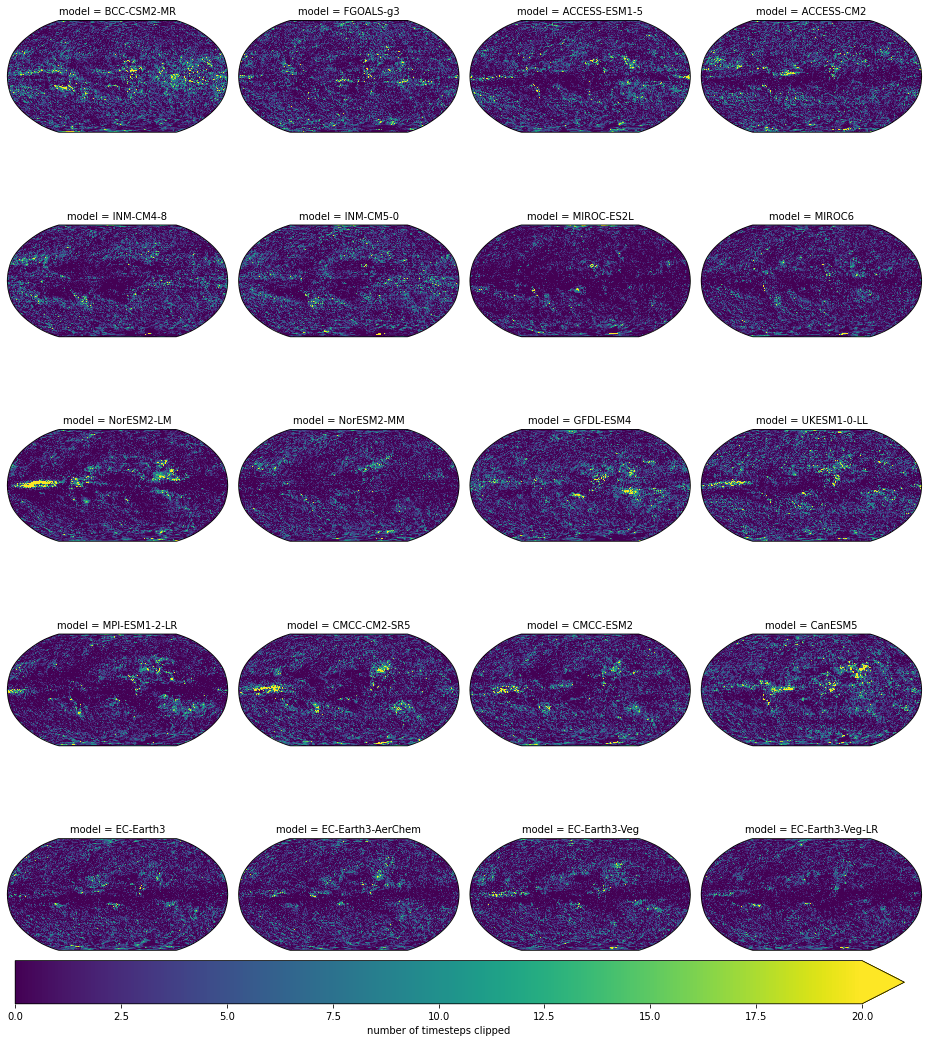

In [9]:
g_simple = ds_allmodels_eager['num_timesteps_clipped'].plot(x='lon',
                                    y='lat',
                                    col='model',
                                    col_wrap=4,
                                    # aspect=ds.dims['longitude'] / ds.dims['latitude'],
                                    subplot_kws=dict(projection=ccrs.Robinson()),
                                    add_colorbar=False,
                                    transform=ccrs.PlateCarree(),
                                    # figsize=(27, 15),
                                    vmin=0,
                                    vmax=20, # cbar_kwargs={'orientation': 'horizontal', 
                                                          # 'label': 'number of timesteps clipped'}
                                                           )

mappable = g_simple.axes[0][0].collections[0]
cax = plt.axes([0.02, 0.02, 0.95, 0.04])
cbar1 = plt.colorbar(mappable, cax=cax, orientation='horizontal', 
                    label='number of timesteps clipped', extend='max')

plt_title ='{variable}_clipping_{time_start}_{time_end}_{scenario}.png'.format(variable=variable, time_start=time_start, time_end=time_end, scenario=scenario)

plt.savefig(os.path.join(plot_dir, plt_title), dpi=200, bbox_inches='tight')

In [10]:
time_start = '1960'
time_end = '1980'
variable = 'pr'
scenario = 'historical'

ds_models = []
models_list = []

for model in models:
    zarr_path = fp.format(variable=variable,
                                            model=model,
                                            scenario=scenario,
                                            time_start=time_start,
                                            time_end=time_end)
    # print(zarr_path)
    if scenario in models[model]:
        ds_models.append(xr.open_zarr(zarr_path, consolidated=True))
        models_list.append(model)
        
ds_allmodels = xr.concat(ds_models, pd.Index(models_list, name="model"))

ds_allmodels_eager = ds_allmodels.compute()

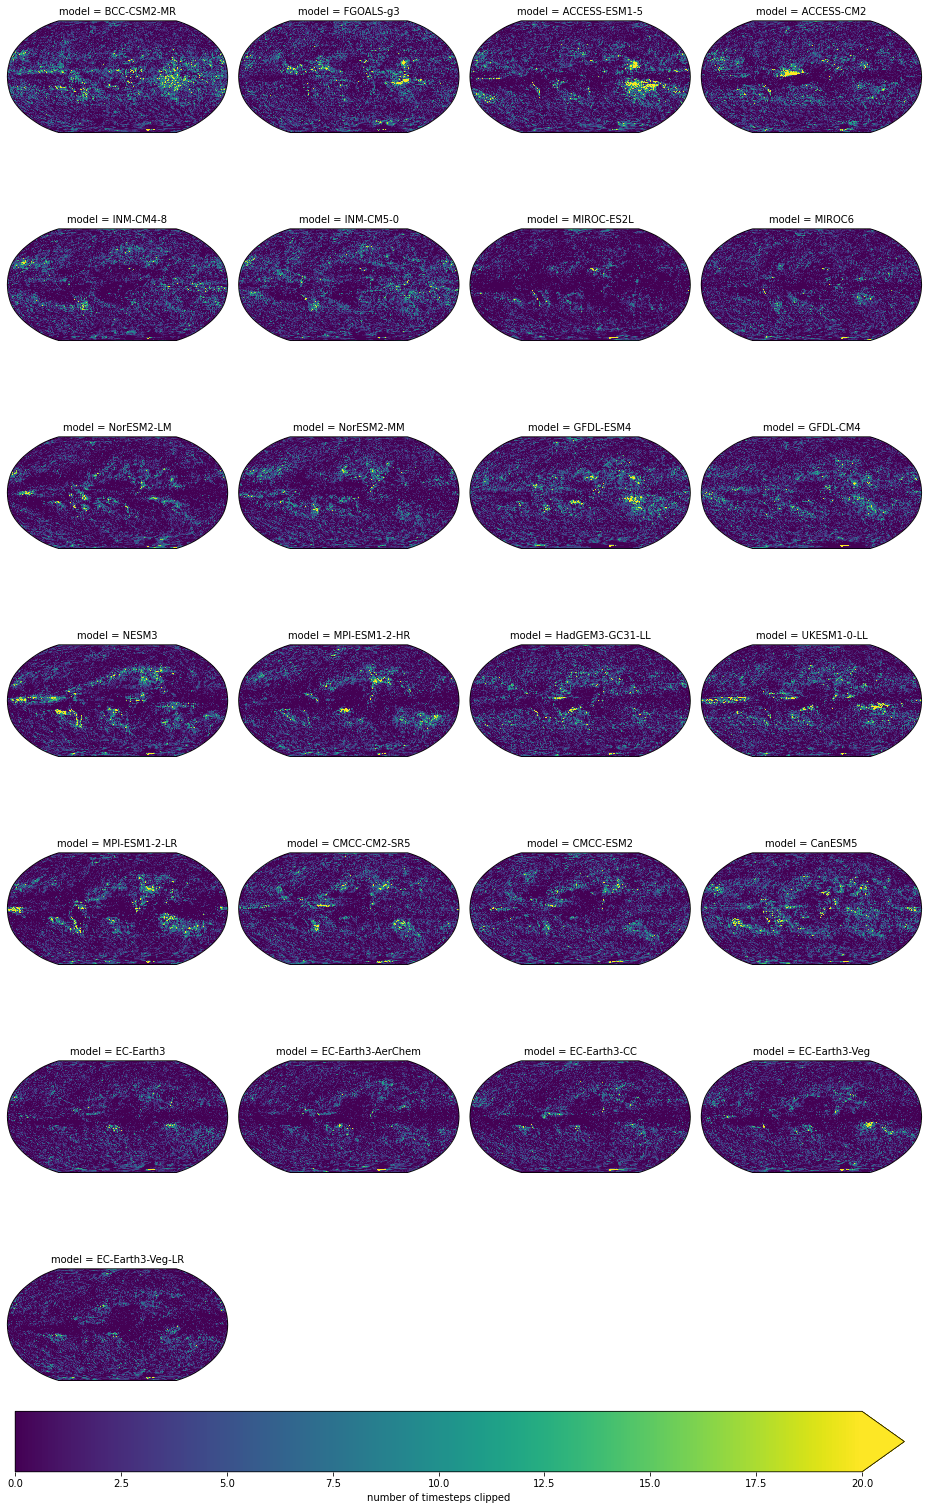

In [13]:
g_simple = ds_allmodels_eager['num_timesteps_clipped'].plot(x='lon',
                                    y='lat',
                                    col='model',
                                    col_wrap=4,
                                    # aspect=ds.dims['longitude'] / ds.dims['latitude'],
                                    subplot_kws=dict(projection=ccrs.Robinson()),
                                    add_colorbar=False,
                                    transform=ccrs.PlateCarree(),
                                    # figsize=(27, 15),
                                    vmin=0,
                                    vmax=20, # cbar_kwargs={'orientation': 'horizontal', 
                                                          # 'label': 'number of timesteps clipped'}
                                                           )

mappable = g_simple.axes[0][0].collections[0]
cax = plt.axes([0.02, -0.01, 0.95, 0.04])
cbar1 = plt.colorbar(mappable, cax=cax, orientation='horizontal', 
                    label='number of timesteps clipped', extend='max')

plt_title ='{variable}_clipping_{time_start}_{time_end}_{scenario}.png'.format(variable=variable, time_start=time_start, time_end=time_end, scenario=scenario)

plt.savefig(os.path.join(plot_dir, plt_title), dpi=200, bbox_inches='tight')

now look at tasmax 

In [16]:
time_start = '2080'
time_end = '2100'
variable = 'tasmax'
scenario = 'ssp370'

ds_models = []
models_list = []

for model in models:
    zarr_path = fp.format(variable=variable,
                                            model=model,
                                            scenario=scenario,
                                            time_start=time_start,
                                            time_end=time_end)
    # print(zarr_path)
    if scenario in models[model]:
        ds_models.append(xr.open_zarr(zarr_path, consolidated=True))
        models_list.append(model)
        
ds_allmodels = xr.concat(ds_models, pd.Index(models_list, name="model"))

ds_allmodels_eager = ds_allmodels.compute()

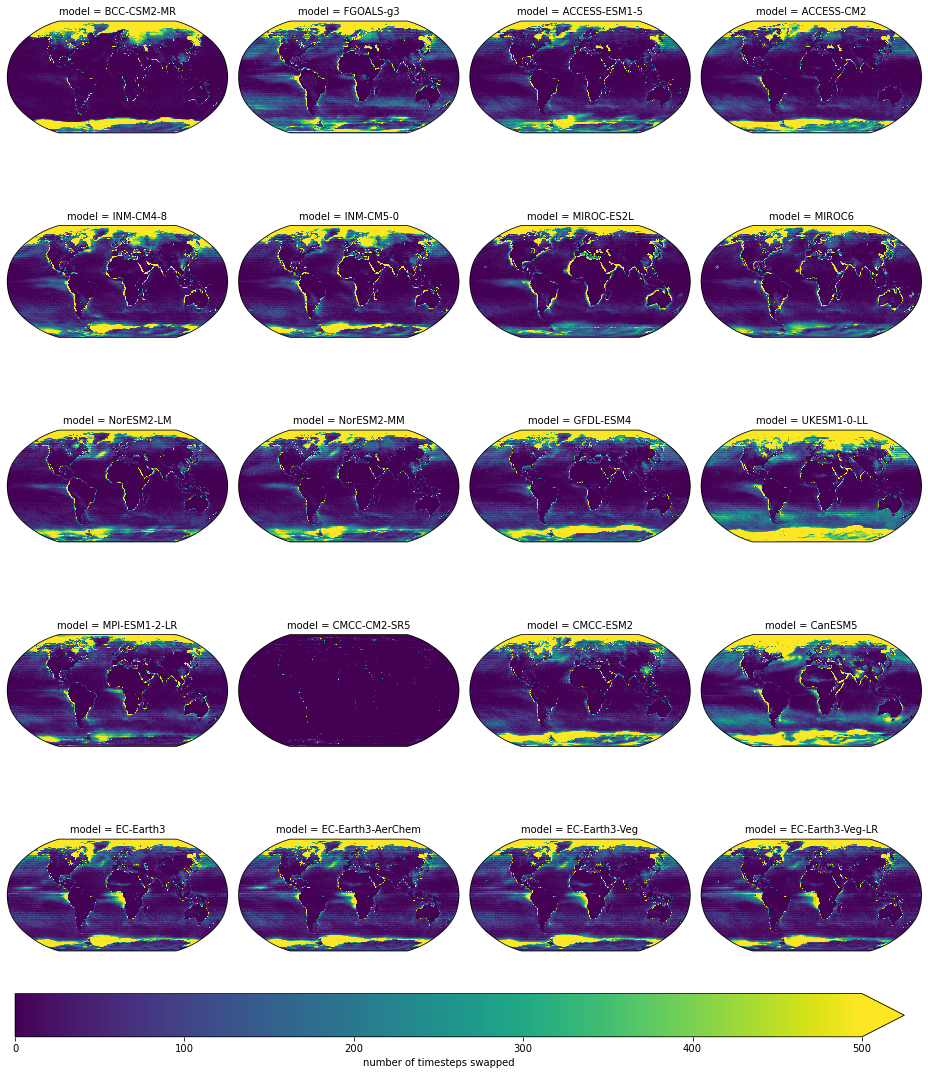

In [17]:
g_simple = ds_allmodels_eager['num_timesteps_clipped'].plot(x='lon',
                                    y='lat',
                                    col='model',
                                    col_wrap=4,
                                    # aspect=ds.dims['longitude'] / ds.dims['latitude'],
                                    subplot_kws=dict(projection=ccrs.Robinson()),
                                    add_colorbar=False,
                                    transform=ccrs.PlateCarree(),
                                    # figsize=(27, 15),
                                    vmin=0,
                                    vmax=500, # cbar_kwargs={'orientation': 'horizontal', 
                                                          # 'label': 'number of timesteps clipped'}
                                                           )

mappable = g_simple.axes[0][0].collections[0]
cax = plt.axes([0.02, -0.01, 0.95, 0.04])
cbar1 = plt.colorbar(mappable, cax=cax, orientation='horizontal', 
                    label='number of timesteps swapped', extend='max')

plt_title ='{variable}_clipping_{time_start}_{time_end}_{scenario}.png'.format(variable=variable, time_start=time_start, time_end=time_end, scenario=scenario)

plt.savefig(os.path.join(plot_dir, plt_title), dpi=200, bbox_inches='tight')

In [18]:
time_start = '1960'
time_end = '1980'
variable = 'tasmax'
scenario = 'historical'

ds_models = []
models_list = []

for model in models:
    zarr_path = fp.format(variable=variable,
                                            model=model,
                                            scenario=scenario,
                                            time_start=time_start,
                                            time_end=time_end)
    # print(zarr_path)
    if scenario in models[model]:
        ds_models.append(xr.open_zarr(zarr_path, consolidated=True))
        models_list.append(model)
        
ds_allmodels = xr.concat(ds_models, pd.Index(models_list, name="model"))

ds_allmodels_eager = ds_allmodels.compute()

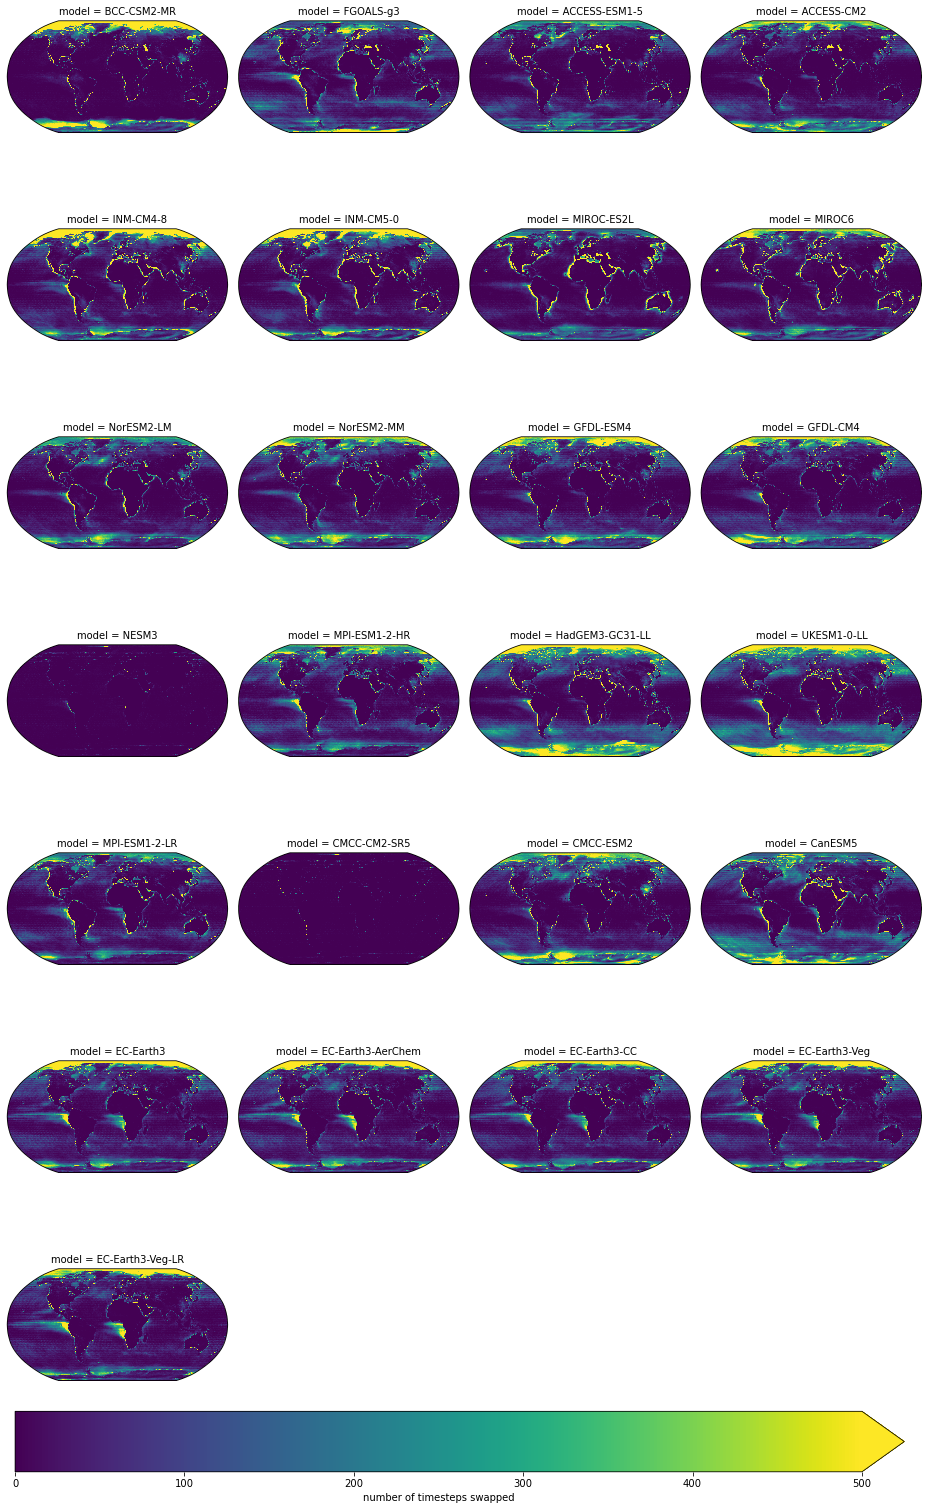

In [19]:
g_simple = ds_allmodels_eager['num_timesteps_clipped'].plot(x='lon',
                                    y='lat',
                                    col='model',
                                    col_wrap=4,
                                    # aspect=ds.dims['longitude'] / ds.dims['latitude'],
                                    subplot_kws=dict(projection=ccrs.Robinson()),
                                    add_colorbar=False,
                                    transform=ccrs.PlateCarree(),
                                    # figsize=(27, 15),
                                    vmin=0,
                                    vmax=500, # cbar_kwargs={'orientation': 'horizontal', 
                                                          # 'label': 'number of timesteps clipped'}
                                                           )

mappable = g_simple.axes[0][0].collections[0]
cax = plt.axes([0.02, -0.01, 0.95, 0.04])
cbar1 = plt.colorbar(mappable, cax=cax, orientation='horizontal', 
                    label='number of timesteps swapped', extend='max')

plt_title ='{variable}_clipping_{time_start}_{time_end}_{scenario}.png'.format(variable=variable, time_start=time_start, time_end=time_end, scenario=scenario)

plt.savefig(os.path.join(plot_dir, plt_title), dpi=200, bbox_inches='tight')